# Development for ER3BP integrator

Yuri Shimane

In [1]:
using LinearAlgebra
using DifferentialEquations
using Plots
using Printf

using FiniteDiff
using ForwardDiff

In [69]:
include("../R3BP/src/R3BP.jl")

Main.R3BP

In [3]:
reltol = 1e-15
abstol = 1e-15
maxiter = 15

15

In [4]:
ecc = 0.02  # to up 0.0549
t0 = 0.0

0.0

In [5]:
function ssdc_halo(p, x0, period0, system="cr3bp", tolnewton=1e-12, maxiter=15, reltol=1e-13, abstol=1e-13)
    # initalize problem
    x0iter = copy(x0)
    period = copy(period0)
    
    # newton iterate
    for i = 1:maxiter
        x0_stm = vcat(x0iter, reshape(I(6), (36,)))[:] 
        #hcat(x0iter, [1 0 0 0 0 0  0 1 0 0 0 0  0 0 1 0 0 0  0 0 0 1 0 0  0 0 0 0 1 0  0 0 0 0 0 1])[:];
        if cmp(system, "cr3bp")==0
            prob = ODEProblem(R3BP.rhs_cr3bp_svstm!, x0_stm, period/2, p);
        else
            prob = ODEProblem(R3BP.rhs_er3bp_svstm!, x0_stm, period/2, p);
        end
        # solve ODE problem
        sol = solve(prob, Tsit5(), reltol=reltol, abstol=abstol);
        # construct stm
        stm = reshape(sol.u[end][7:end], (6,6))';
        
        # get state derivative at the end
        statef = sol.u[end]

        # Newton solver, fix Z
        #      x,         z,         vy
        xi = [ x0iter[1], x0iter[3], x0iter[5] ]
        # correction on: y, vx, vz
        df = [ stm[2,1] stm[2,3] stm[2,5];     # dy/dx, dy/dz, dy/dvy
               stm[4,1] stm[4,3] stm[4,5];     # dvx/dx, dvx/dz, dvx/dvy
               stm[6,1] stm[6,3] stm[6,5] ];   # dvz/dx, dvz/dz, dvz/dvy

        # correct state
        ferr = [ statef[2], statef[4], statef[6] ]
        @printf("Iter %i, |ferr| = %1.6e\n", i, norm(ferr))
        if norm(ferr) < tolnewton
            @printf("Newton convered after %i iterations, ferr = %1.6e\n", i, norm(ferr))
            break
        end
        xii = xi - inv(df)*ferr

        # store next solution, fix Z
        x0iter[1] = xii[1];   # overwrite x
        x0iter[3] = xii[2];   # overwrite z
        x0iter[5] = xii[3];   # overwrite vy
    end
    
    return x0iter, period
end

ssdc_halo (generic function with 6 methods)

In [6]:
# define parameters
mu = 0.01215058426994;
X0 = [1.143749298238092, 0.0, -0.157507529813055, 0.0, -0.221868721418453, 0.0];
T = π;

In [7]:
X0corr, Tcorr = ssdc_halo((mu), X0, T)

Iter 1, |ferr| = 2.541335e-07
Iter 2, |ferr| = 1.087477e-13
Newton convered after 2 iterations, ferr = 1.087477e-13


([1.1437492946706134, 0.0, -0.15750752193940878, 0.0, -0.22186871318299284, 0.0], π)

In [8]:
tspan = (0.0, T)
p = (mu)
prob = ODEProblem(R3BP.rhs_cr3bp_sv!, X0corr, tspan, p)
sol = DifferentialEquations.solve(prob, Tsit5(), reltol=reltol, abstol=abstol);

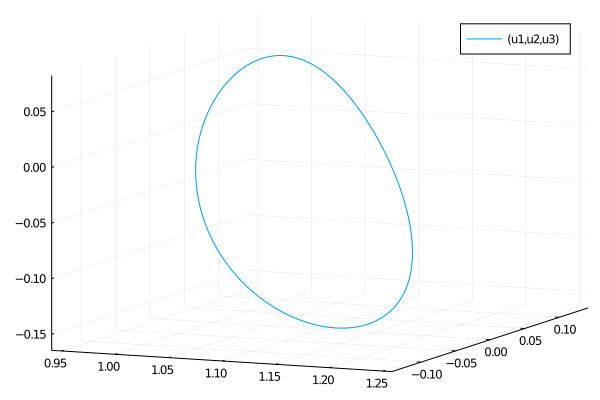

In [9]:
plot(sol, vars=(1,2,3))

In [10]:
tspan = (0.0, T)
pe = (mu,ecc,t0)
probe = ODEProblem(R3BP.rhs_er3bp_sv!, X0corr, tspan, pe)
sole = DifferentialEquations.solve(probe, Tsit5(), reltol=reltol, abstol=abstol);

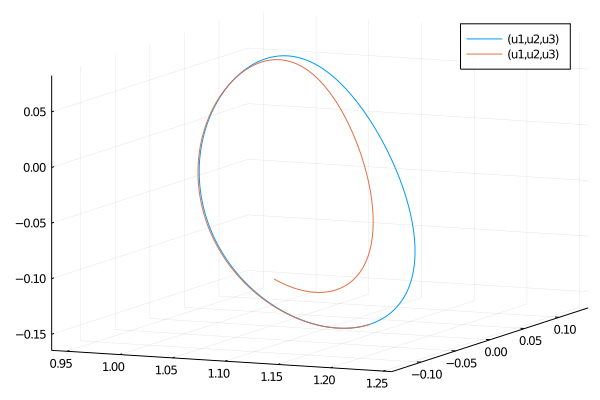

In [11]:
p = plot()
plot!(p, sol, vars=(1,2,3))
plot!(p, sole, vars=(1,2,3))
p

#### Check monodormy for CR3BP case

In [12]:
# analytical propagation
tspan = (0.0, T)
p = (mu)
prob = ODEProblem(R3BP.rhs_cr3bp_svstm!, vcat(X0corr, reshape(I(6), (36,)))[:], tspan, p)
solcr3bpstm = DifferentialEquations.solve(prob, Tsit5(), reltol=reltol, abstol=abstol);
stm_cr3bp_analytical = reshape(solcr3bpstm.u[end][7:end], (6,6))'

6×6 Adjoint{Float64,Array{Float64,2}}:
  75.0475  -50.1464   -47.4147    44.7942    7.40534    -9.01764
 -11.55      8.46924    8.58197   -7.40534  -1.18717     0.825656
 -13.9753    9.60681    9.78107   -9.01764  -0.825656    1.41974
 100.458   -66.807    -63.0455    60.2368    9.17569   -12.324
 -66.3495   44.7574    42.6924   -39.4421   -6.34145     8.42847
 -80.2094   52.1369    50.0723   -47.4147   -8.58197     9.78107

In [13]:
# wrapper function
function propagate_cr3bp(x0, tf, p)
    prob = ODEProblem(R3BP.rhs_cr3bp_sv!, x0, (0, tf), p)
    sol = DifferentialEquations.solve(prob, Tsit5(), reltol=reltol, abstol=abstol);
    return sol.u[end]
end

propagate_cr3bp (generic function with 1 method)

In [14]:
stm_cr3bp_ad = ForwardDiff.jacobian(X0corr -> propagate_cr3bp(X0corr, T, (mu)), X0corr)

6×6 Array{Float64,2}:
  75.0475  -50.1464   -47.4147    44.7942    7.40534    -9.01764
 -11.55      8.46924    8.58197   -7.40534  -1.18717     0.825656
 -13.9753    9.60681    9.78107   -9.01764  -0.825656    1.41974
 100.458   -66.807    -63.0455    60.2368    9.17569   -12.324
 -66.3495   44.7574    42.6924   -39.4421   -6.34145     8.42847
 -80.2094   52.1369    50.0723   -47.4147   -8.58197     9.78107

In [15]:
stm_cr3bp_analytical - stm_cr3bp_ad

6×6 Array{Float64,2}:
  7.80176e-12  -4.17089e-12  -2.99138e-12  …   1.63336e-12  -5.7554e-13
  6.18172e-13  -6.27054e-13  -7.90479e-13     -1.09246e-13  -5.70655e-14
 -3.46567e-12   2.04281e-12   1.66978e-12     -5.47673e-13   3.48166e-13
  1.8062e-11   -1.07008e-11  -8.93152e-12      2.87947e-12  -1.58273e-12
 -5.42855e-12   2.65032e-12   1.63425e-12     -1.26121e-12   3.74811e-13
 -1.6982e-11    1.02105e-11   8.73968e-12  …  -2.60059e-12   1.66445e-12

In [16]:
# Analytical eigenvalues
eigvals(stm_cr3bp_analytical)

6-element Array{Complex{Float64},1}:
 -0.22422818462266736 - 0.9745366700236823im
 -0.22422818462266736 + 0.9745366700236823im
 0.006434337171071673 + 0.0im
   0.9999999999986731 - 1.6163488275371462e-6im
   0.9999999999986731 + 1.6163488275371462e-6im
   155.41616384343254 + 0.0im

In [17]:
# AD based eigenvalues
eigvals(stm_cr3bp_ad)

6-element Array{Complex{Float64},1}:
 -0.22422818462274477 - 0.9745366700236622im
 -0.22422818462274477 + 0.9745366700236622im
 0.006434337171039147 + 0.0im
   0.9999999999987244 - 1.6088728245947165e-6im
   0.9999999999987244 + 1.6088728245947165e-6im
   155.41616384341353 + 0.0im

### Propagation with STM

In [18]:
X0stm = vcat(X0corr, reshape(I(6), (36,)))[:];

In [19]:
tspan = (0.0, T)
pe = (mu,ecc,t0)
probes = ODEProblem(R3BP.rhs_er3bp_svstm!, X0stm, tspan, pe)
soles = DifferentialEquations.solve(probes, Tsit5(), reltol=reltol, abstol=abstol);

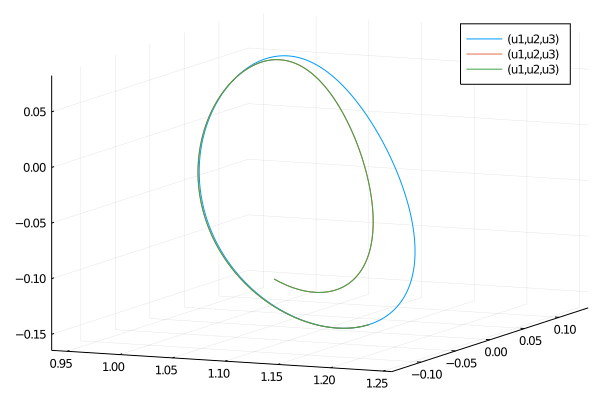

In [20]:
p = plot()
plot!(p, sol, vars=(1,2,3))
plot!(p, sole, vars=(1,2,3))
plot!(p, soles, vars=(1,2,3))
p

In [21]:
stm_er3bp_analytical = reshape(soles.u[end][7:end], (6,6))'

6×6 Adjoint{Float64,Array{Float64,2}}:
   68.7056   -47.0316   -44.9573   41.9738     6.19768    -8.35445
   -2.25906    2.06301    2.5702   -1.70703   -0.313402   -0.0930771
  -32.494     22.1879    21.9918  -20.3269    -2.48846     3.86223
   92.5546   -63.3928   -61.0135   57.3831     7.00677   -11.4062
  -40.2978    27.4013    25.8821  -23.8336    -3.60349     5.8446
 -150.019    100.893     97.35    -91.1793   -14.0014     18.5438

In [22]:
# wrapper function
function propagate_er3bp(x0, tf, p)
    prob = ODEProblem(R3BP.rhs_er3bp_sv!, x0, (0, tf), p)
    sol = DifferentialEquations.solve(prob, Tsit5(), reltol=reltol, abstol=abstol);
    return sol.u[end]
end

propagate_er3bp (generic function with 1 method)

In [92]:
prob = ODEProblem(R3BP.rhs_er3bp_sv!, X0corr, (0, T), p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 3.141592653589793)
u0: [1.1437492946706134, 0.0, -0.15750752193940878, 0.0, -0.22186871318299284, 0.0]

In [95]:
function er3bp_statef(x0, tf, p)
    _prob = remake(prob, u0=x0, p=p)
    sol = solve(_prob,Tsit5(), saveat=tf)
    sol.u[end]
end

LoadError: [91msyntax: extra token ")" after end of expression[39m

In [93]:
stm_ad = ForwardDiff.jacobian(X0corr -> er3bp_statef(X0corr, pe), X0corr)

LoadError: [91mDimensionMismatch("jacobian(f, x) expexts that f(x) is an array. Perhaps you meant gradient(f, x)?")[39m

In [23]:
propagate_er3bp(X0corr, T, pe)

6-element Array{Float64,1}:
  1.0464351249602326
  0.010476385031073059
 -0.12451702561273176
 -0.13532259439463412
 -0.14830158923562528
  0.14734225387450278

In [24]:
stm_fd = FiniteDiff.finite_difference_jacobian(X0corr -> propagate_er3bp(X0corr, T, pe), X0corr)

6×6 Array{Float64,2}:
   68.6975   -47.0482  -44.9602    41.9862     6.20468   -8.30311
   -2.23658    2.0547    2.54964   -1.69786   -0.31064   -0.10485
  -32.553     22.2305   22.0184   -20.3652    -2.50584    3.84394
   92.6579   -63.4773  -61.0739    57.4589     7.03821  -11.3536
  -40.2989    27.4117   25.9008   -23.8433    -3.60665    5.82071
 -149.971    100.888    97.3193   -91.1708   -14.0305    18.4366

In [25]:
stm_ad = ForwardDiff.jacobian(X0corr -> propagate_er3bp(X0corr, T, pe), X0corr)

6×6 Array{Float64,2}:
   68.6974   -47.0482   -44.9602    41.9861     6.20467   -8.30311
   -2.23653    2.05473    2.54967   -1.69784   -0.31064   -0.104849
  -32.5531    22.2304    22.0184   -20.3652    -2.50584    3.84394
   92.6576   -63.4775   -61.074     57.4588     7.03819  -11.3536
  -40.2987    27.4118    25.9009   -23.8432    -3.60664    5.82071
 -149.972    100.888     97.319    -91.171    -14.0305    18.4366

In [26]:
stm_fd - stm_ad

6×6 Array{Float64,2}:
  9.84439e-5    3.77121e-5    1.87764e-5   …   7.86804e-6  -4.12458e-7
 -5.73784e-5   -2.55782e-5   -2.33377e-5      -4.08028e-7  -5.44594e-7
  0.000116773   4.6662e-5     5.05033e-5      -2.57019e-6   2.60595e-6
  0.00032247    0.000126436   8.8791e-5        1.29734e-5   1.55468e-6
 -0.00026371   -0.000111213  -0.00010129      -5.9371e-6   -1.35833e-6
  0.000600459   0.000247292   0.000264443  …  -1.17051e-5   1.13221e-5

In [27]:
stm_er3bp_analytical - stm_ad

6×6 Array{Float64,2}:
  0.00817944   0.0166699    0.00289558  -0.0123657   -0.00698676  -0.0513348
 -0.0225353    0.00828327   0.0205313   -0.00918185  -0.00276247   0.0117722
  0.0590459   -0.0425096   -0.0265325    0.0382506    0.0173826    0.0182902
 -0.103045     0.0846874    0.0605595   -0.0756752   -0.031428    -0.0526027
  0.00082328  -0.0105215   -0.0187763    0.00965056   0.00315181   0.0238918
 -0.047561     0.00482717   0.0310135   -0.00837008   0.0290542    0.107207

In [28]:
X0corr

6-element Array{Float64,1}:
  1.1437492946706134
  0.0
 -0.15750752193940878
  0.0
 -0.22186871318299284
  0.0

In [29]:
T, pe

(π, (0.01215058426994, 0.02, 0.0))

In [30]:
maxiter = 15
# it seems convergence is better for 2 pi
X0corr_er3bp, Tcorr_er3bp = ssdc_halo(pe, X0corr, 2T, "er3bp", 1e-12, maxiter, reltol, abstol)

Iter 1, |ferr| = 2.003290e-01
Iter 2, |ferr| = 2.952534e-02
Iter 3, |ferr| = 7.081225e-02
Iter 4, |ferr| = 4.773150e-03
Iter 5, |ferr| = 1.893487e-03
Iter 6, |ferr| = 6.502321e-06
Iter 7, |ferr| = 1.970242e-08
Iter 8, |ferr| = 5.329306e-10
Iter 9, |ferr| = 1.026828e-12
Iter 10, |ferr| = 1.859801e-14
Newton convered after 10 iterations, ferr = 1.859801e-14


([1.144214679137861, 0.0, -0.15880960084352558, 0.0, -0.22151207247882534, 0.0], 6.283185307179586)

In [31]:
T, ecc

(π, 0.02)

In [32]:
tspan = (0.0, 2π)
pe = (mu, ecc, t0)
probcorr_e = ODEProblem(R3BP.rhs_er3bp_sv!, X0corr_er3bp, tspan, pe)
solcorr_e = DifferentialEquations.solve(probcorr_e, Tsit5(), reltol=reltol, abstol=abstol);
solcorr_e.u[end]

6-element Array{Float64,1}:
  1.144214679154676
 -2.7684991835606005e-12
 -0.1588096008467559
  2.206398264786265e-11
 -0.2215120724938155
 -1.753542102661889e-11

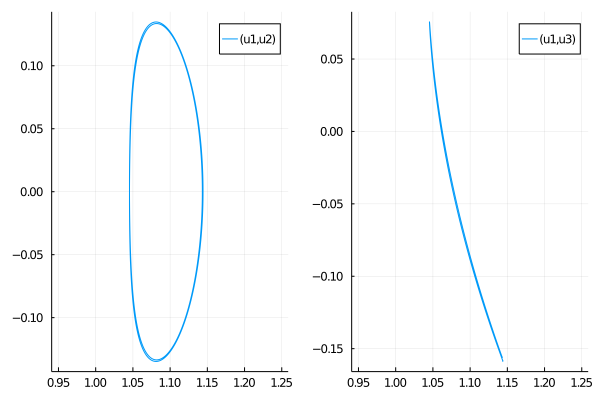

In [33]:
p1 = plot(solcorr_e, vars=(1,2))
p2 = plot(solcorr_e, vars=(1,3))
plot(p1,p2)

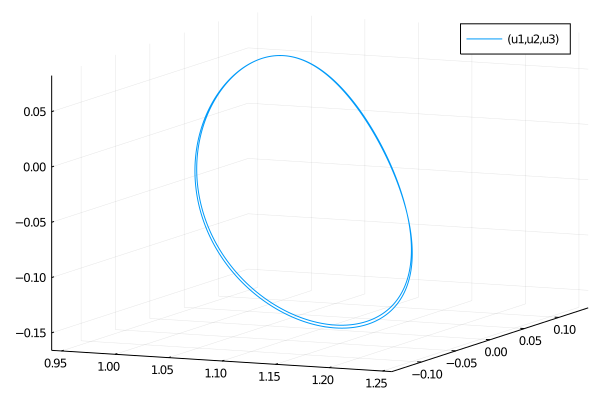

In [34]:
p = plot()
# plot!(p, sol, vars=(1,2,3))
# plot!(p, sole, vars=(1,2,3))
plot!(p, solcorr_e, vars=(1,2,3))
p

In [35]:
X0corr, T

([1.1437492946706134, 0.0, -0.15750752193940878, 0.0, -0.22186871318299284, 0.0], π)

In [36]:
# correction with function
rese = R3BP.ssdc_periodic_xzplane(pe, X0corr, 2T, system="er3bp")

Converged at iteration 10


Main.R3BP.Struct_out_ssdc([1.1442146791378616, 0.0, -0.1588096008435236, 0.0, -0.2215120724788166, 0.0], 6.283185307179586, 1)

In [37]:
rese.period, reltol, abstol

(6.283185307179586, 1.0e-15, 1.0e-15)

### Continuation until eccentricity of interest

In [70]:
#probfun = ODEProblem(R3BP.rhs_er3bp_sv!, rese.x0, (0.0, rese.period), pe)
pe = (mu, ecc, t0)
probfun = ODEProblem(R3BP.rhs_er3bp_sv!, rese.x0, (0.0, 2π), pe)
solfun = DifferentialEquations.solve(probfun, Tsit5(), reltol=reltol, abstol=abstol);

In [71]:
T

π = 3.1415926535897...

In [85]:
ecc_obj = 0.1  # 0.0549   # final eccentricty to get to
ecc_step = 0.02
ecc_current = 0.0
X0init = X0corr
Tinit = π
ecc_list = []
res_list = []
sol_list = []
iter = 0

while ecc_current < ecc_obj
    iter += 1
    # update on eccentricity
    decc = min(ecc_step, ecc_obj - ecc_current)
    ecc_current += decc
    push!(ecc_list, ecc_current)
    println("iter $iter, e = ecc_current")
    
    # solve next iteration
    pe = (mu, ecc_current, t0)
    res = R3BP.ssdc_periodic_xzplane(pe, X0init, 2π, system="er3bp", tolDC=1e-12)
    X0init = copy(res.x0)
    push!(res_list, res) 
end

iter 1, e = ecc_current
Converged at iteration 10
iter 2, e = ecc_current
Converged at iteration 10
iter 3, e = ecc_current
Converged at iteration 11
iter 4, e = ecc_current
Converged at iteration 11
iter 5, e = ecc_current
Converged at iteration 11


In [86]:
res_list[1].fiters

10-element Array{Any,1}:
 0.20032897687010048
 0.029525337239348325
 0.0708122539833513
 0.00477314998956499
 0.0018934865136052354
 6.502320674569206e-6
 1.9702465004237457e-8
 5.329424643191203e-10
 1.0221909889104816e-12
 8.87209159892396e-14

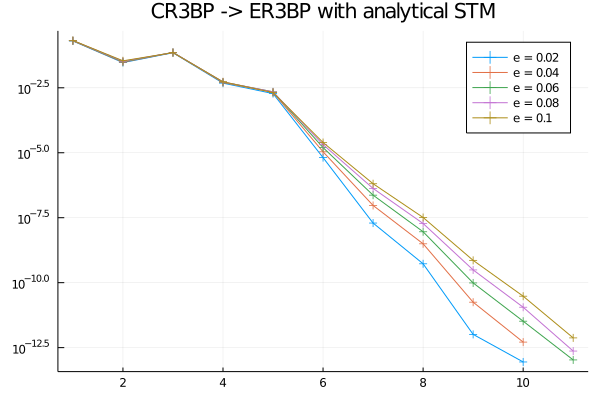

In [90]:
pf = plot(title="CR3BP -> ER3BP with analytical STM")
for i = 1:length(res_list)
    nf = length(res_list[i].fiters)
    e_of_plot = ecc_list[i]
    plot!(pf, LinRange(1, nf, nf), res_list[i].fiters, yaxis=:log, label="e = $e_of_plot", marker=:cross)
end
pf

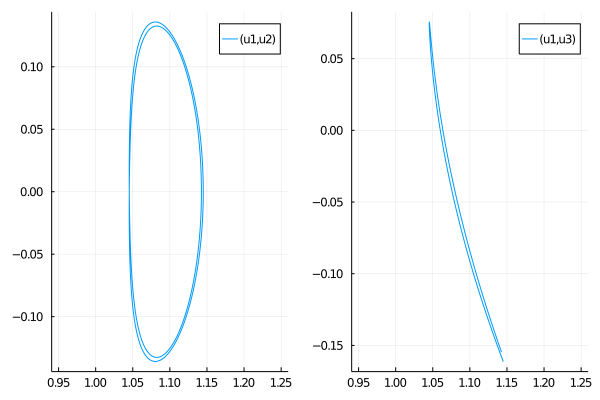

In [63]:
p1 = plot(res_list[end].sol, vars=(1,2))
p2 = plot(res_list[end].sol, vars=(1,3))
plot(p1,p2)

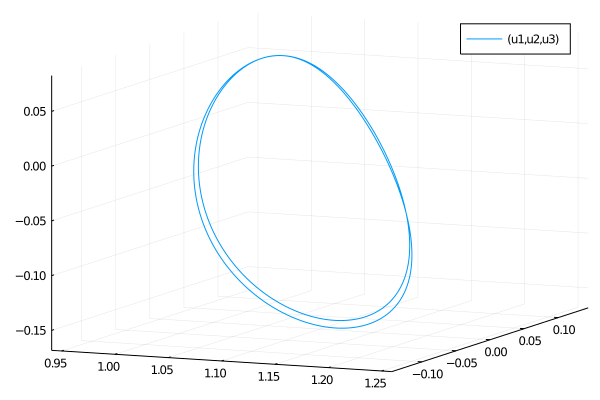

In [64]:
p = plot()
# plot!(p, sol, vars=(1,2,3))
# plot!(p, sole, vars=(1,2,3))
plot!(p, res_list[end].sol, vars=(1,2,3))
p

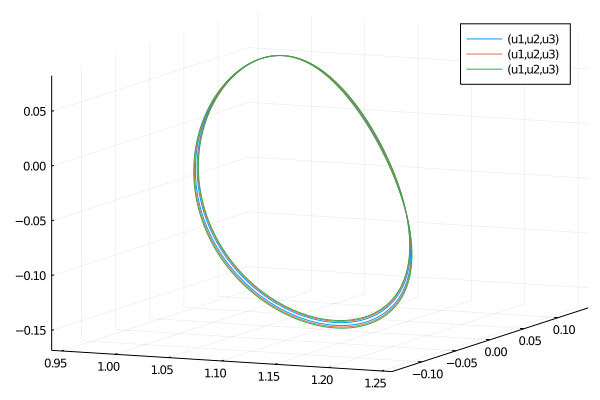

In [65]:
p = plot()
for i = 1:length(sol_list)
    plot!(p, res_list[i].sol, vars=(1,2,3))
end
p